# Bayesian Linear Regression + Pyro

# Часть 1. Sequential updating
Начнем с того, что продемонстрируем возможноть Байесовских моделей работать в онлайн режиме.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.stats import multivariate_normal as mvn
from numpy.polynomial.polynomial import polyval

%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse

Рассмотрим следующую модель:
    
\begin{equation*}
    \begin{aligned}
    & p(t_n|x_n, w;\beta) = \mathcal{N}(t_n| \textbf{w}^Tx_n, \beta^{-1}), \\
    & p(\textbf{t}|X,\textbf{w};\beta) = \prod\limits_{n=1}^{N}p(t_n|x_n, \textbf{w};\beta) = \mathcal{N}(\textbf{t}|X\textbf{w}, \beta^{-1}), \\
    & p(\textbf{w};\alpha) = \prod\limits_{d=1}^{D}\mathcal{N}(w_d|0, \alpha_d^{-1})=\mathcal{N}(\textbf{w}|0,A^{-1}).
    \end{aligned}
\end{equation*}  

Рассмотрим два набора данных:
$$
p\left(\mathbf{w} \mid(X, \mathbf{t})^{1},(X, \mathbf{t})^{2}\right) \propto \underbrace{p(\mathbf{w}) p\left((X, \mathbf{t})^{1} \mid \mathbf{w}\right)}_{\text {Posterior after first data chunk }} p\left((X, \mathbf{t})^{2} \mid \mathbf{w}\right) \propto \underbrace{p\left(\mathbf{w} \mid(X, \mathbf{t})^{1}\right)}_{\text {New prior is "old" posterior }} p\left(\left(X, \mathbf{w}^{2}\right) \mid \mathbf{w}\right)
$$

Для последовательного обновления можно явно вычислить формулы обновления параметров распределения:


- Наблюдаем $(X,\textbf{t})^{1}$ и получаем:

    $$\Sigma_{w}^{-1} = [\beta X_{(1)}^TX_{(1)} + A]$$
    $$\mu_{w} = \Sigma_{w}\beta X^T_{(1)}\textbf{t}_{(1)}$$
    
    
- Наблюдаем $(X,\textbf{t})^{2}$ и для следующего шага получаем:

    $$\Sigma_{w,(1,2)}^{-1} = [\beta X_{(2)}^T X_{(2)} + \Sigma_{w}^{-1}]$$
    
    $$\mu_{w,(1,2)} = \Sigma_{w,(1,2)}(\beta X_{(2)}^T\textbf{t}_{(2)}+\Sigma^{-1}_w\mu_w)$$

- $\dots$

##### Task 1.1
Дописать метод <i>update_w</i>.

In [ ]:
class BLR:
    def __init__(self, A, beta, x_dim=2):
        self.w_Pr = {'mu': np.zeros(x_dim), 'cov': np.linalg.inv(A), 'inv_cov': A}
        self.beta = beta
        
    def update_w(self, X, y, verbose=False):
        inv_cov = self.beta * X.T @ X + self.w_Pr['inv_cov'] # write code here
        cov = np.linalg.inv(inv_cov) # write code here
        mu = cov @ (self.beta * X.T @ y[:, None] + self.w_Pr['inv_cov'] @ self.w_Pr['mu'][:, None]) # write code here
        
        self.w_Pr = {'mu': mu.flatten(), 'cov': cov, 'inv_cov': inv_cov}
        return {'mu': mu.flatten(), 'cov': cov, 'inv_cov': inv_cov} if verbose else 0.0
    
    def plot_w_space(self, ax, b=15.):
        xx, yy = np.mgrid[-b:b:0.01, -b:b:0.01]
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = mvn.logpdf(grid, mean=self.w_Pr['mu'], cov=self.w_Pr['cov'])
        contour = ax.contourf(xx,yy,probs.reshape(xx.shape))
        
    def plot_poly_data_space(self, x, y, ax, k=2):
        k_points = np.linspace(-1.1, 1.1, num=k+1)
        for i in range(50):
            w = np.random.multivariate_normal(self.w_Pr['mu'], self.w_Pr['cov'])
            poly_values = np.zeros_like(k_points)
            poly_values = polyval(k_points, w)
            ax.plot(k_points, poly_values, 'r-', alpha=0.15)
        
        ax.scatter(x[:,:,1].flatten(), y.flatten(), edgecolor="white", alpha=0.75, color='blue')
        ax.scatter(x[-1,:,1].flatten(), y[-1].flatten(), edgecolor="white", alpha=1., color='green')
        
    def plot_data_space(self, x, y, ax):
        a, b = (-1.1, 1.1) 
        for i in range(50):
            w = np.random.multivariate_normal(self.w_Pr['mu'], self.w_Pr['cov'])
            ax.plot(np.array([a,b]), np.array([w[0]+w[1]*a, w[0]+w[1]*b]), 'r-', alpha=0.15)
        ax.scatter(x[:,:,1].flatten(), y.flatten(), edgecolor="white", alpha=0.75, color='blue')
        ax.scatter(x[-1,:,1].flatten(), y[-1].flatten(), edgecolor="white", alpha=1., color='green')

Теперь можем проверить полученный код на простом примере

In [ ]:
np.random.seed(3)
x1 = np.linspace(-1, 1, 10)
np.random.shuffle(x1)
x1 = x1.reshape(5, 2)

y = 1.5 + 12. * x1
y += np.random.randn(*y.shape) * 3.5

x0 = np.ones_like(x1)
X = np.stack([x0, x1], axis=-1)

In [ ]:
reg = BLR(np.diag([0.01, 0.01]), 1.)

Разделим данные на 5 кусков

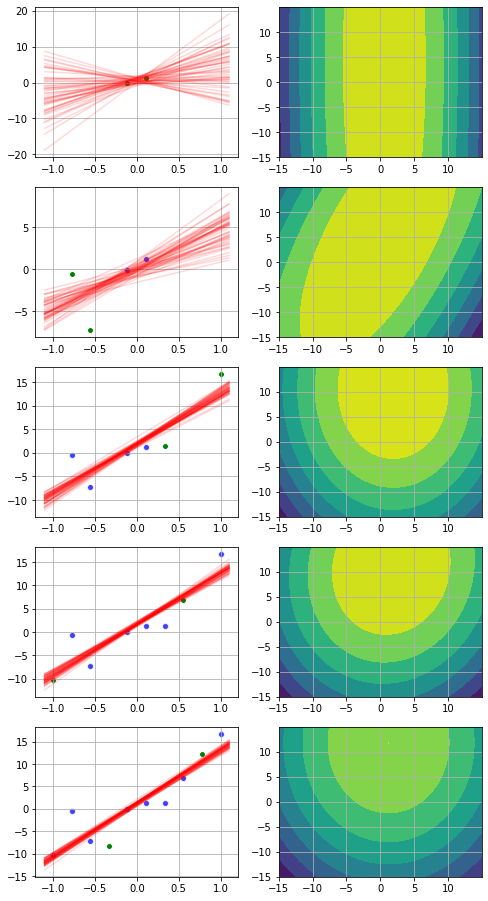

In [ ]:
chunks = 5
fig, ax = plt.subplots(chunks,2, figsize=(8,16))
for i in range(chunks):
    reg.update_w(X[i], y[i])
    reg.plot_data_space(X[:i+1], y[:i+1], ax[i,0])
    reg.plot_w_space(ax[i,1])
for i in ax.flatten(): i.grid()

Рассмотрим более сложный пример с нелинейностью

In [ ]:
np.random.seed(42)
N = 100
chunks = 10
x1 = np.linspace(-1, 1, N)
x1 = x1.reshape(chunks, N//chunks)

y = np.sin(1/x1) * x1
y += np.random.randn(*y.shape) * 0.1

x0 = np.ones_like(x1)
x2 = x1 ** 2
x3 = x1 ** 3
x4 = x1 ** 4
X = np.stack([x0, x1, x2, x3, x4], axis=-1)

In [ ]:
reg = BLR(np.diag([1.,1.,1.,1.,1]), 25., x_dim=5)

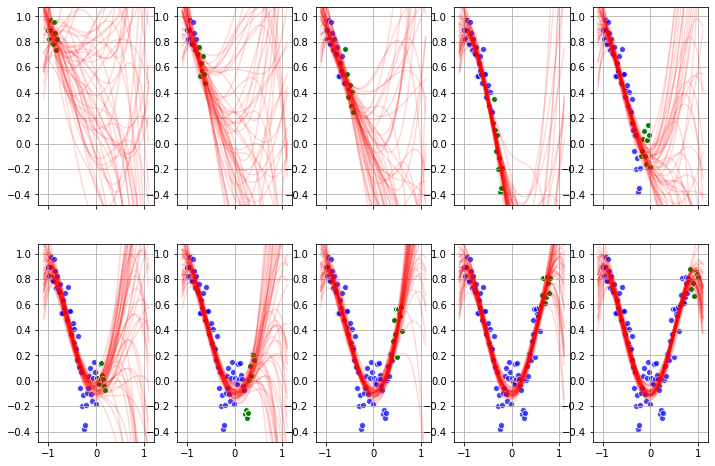

In [ ]:
fig, ax = plt.subplots(chunks//5, 5, figsize=(12, 4*chunks//5), sharex=True)

for i, a in enumerate(ax.flatten()):
    reg.update_w(X[i], y[i])
    reg.plot_poly_data_space(X[:i+1], y[:i+1], a, k=50)
    a.set_ylim(y.min()-0.1, y.max()+0.1)
for i in ax.flatten(): i.grid()

Мы видим, что модель по прежнему хорошо прогнозирует первые куски данных

### Toy Automatic Relevance Determination (Regression) Implementation

Вернемся к нашей модели:
    
\begin{equation*}
    \begin{aligned}
    & p(t_n|x_n, w;\beta) = \mathcal{N}(t_n| \textbf{w}^Tx_n, \beta^{-1}), \\
    & p(\textbf{t}|X,\textbf{w};\beta) = \prod\limits_{n=1}^{N}p(t_n|x_n, \textbf{w};\beta) = \mathcal{N}(\textbf{t}|X\textbf{w}, \beta^{-1}), \\
    & p(\textbf{w};\alpha) = \prod\limits_{d=1}^{D}\mathcal{N}(w_d|0, \alpha_d^{-1})=\mathcal{N}(\textbf{w}|0,A^{-1}).
    \end{aligned}
\end{equation*}  

Чтобы сделать оптимизацию по параметрам $\alpha$ и $\beta$ мы рассматриваем следующую задачу:

$$
\max\limits_{\alpha,\beta}\tfrac{N}{2}\log\beta+\tfrac{1}{2}\log|A|- \tfrac{1}{2}\log|\left(\beta X^TX+A\right)|-\tfrac{\beta}{2}\|\textbf{t}-X\mu\|_2^2 -\tfrac{1}{2}\mu^TA\mu.
$$

Эту задачу можно решить итеративно:

\begin{equation*}
\begin{aligned}
& \mu^{new} = \beta(\beta X^T X + A)^{-1}X^T\textbf{t},\\
& \alpha_i^{new} = \frac{1}{\mu^2_i}(1-\Sigma_{ii}^{old}\alpha_i^{old}),\\
& \beta^{new} = \frac{1}{\|t-X\mu\|_2^2}\left(N-\text{trace} (I-\Sigma^{old}A^{old})\right),\\
& \Sigma^{new} = (\beta^{new} X^TX + A^{new})^{-1}.\\
\end{aligned}
\end{equation*}

##### Task 2.1
Дописать методы <i>update_%smth%</i>.

In [ ]:
class ARD:
    def __init__(self, data):
        self.X = data[0]
        self.t = data[1]
        
        self.alpha = np.array([0.1] * self.X.shape[1])
        self.beta = 1.
        self.Sigma = None
        
        self.data_cov = None
        self.data_mu = None
        
        self.idx_relevant = np.array(range(self.X.shape[1]))
        
    def data_params(self):
        data_cov = self.X.T @ self.X
        data_mu = self.X.T @ self.t
        return data_cov, data_mu
    
    def get_sigma(self): # fix it, no need to invert
        return np.linalg.inv(self.beta * self.data_cov + np.diag(self.alpha))
    
    @staticmethod
    def update_mu(Sigma, beta, data_mu):
        return beta * Sigma @ data_mu # write code here
    
    @staticmethod
    def update_alpha(Sigma, beta, mu, alpha):
        sigma_diag = np.diag(Sigma)# write code here
        return (1- sigma_diag * alpha) / mu ** 2 # write code here
    
    @staticmethod
    def update_beta(Sigma, alpha, mu, X, t):
        N = X.shape[0]
        sigma_diag = np.diag(Sigma)
        return (N - np.sum(1 - sigma_diag * alpha)) / np.linalg.norm(t - X @ mu) ** 2 # write code here
    
    def update_step(self):
        mu = self.update_mu(self.Sigma, self.beta, self.data_mu)
        alpha = self.update_alpha(self.Sigma, self.beta, mu, self.alpha)
        beta = self.update_beta(self.Sigma, self.alpha, mu, self.X, self.t)
        return mu, alpha, beta
    
    def elbo(self):
        N = self.X.shape[0]
        lbound = N * np.log(self.beta) + np.sum(np.log((self.alpha))) - self.beta * np.linalg.norm(self.X @ self.mu - self.t) ** 2\
        - np.sum(self.mu ** 2 * self.alpha) + np.log(np.linalg.det(self.Sigma))
        return lbound
    
    def prune(self, threshold):
        idx = np.where(self.alpha < threshold)[0]
        if len(idx) != 0:
            bad = np.where(self.alpha >= threshold)[0]
            temp = self.idx_relevant[np.where(self.idx_relevant != -1)] 
            temp[bad] = -1
            self.idx_relevant[np.where(self.idx_relevant != -1)] = temp
            
            self.X = self.X[:, idx]
            self.alpha = self.alpha[idx]
            self.mu = self.mu[idx]
            self.data_cov, self.data_mu = self.data_params()
            
            
    def fit(self, prune=1e5, max_iter=10):
        self.data_cov, self.data_mu = self.data_params()
        
        for i in range(max_iter):
            self.Sigma = self.get_sigma()
            self.mu, self.alpha, self.beta = self.update_step()
            if prune is not None:
                self.prune(prune)
            else:
                self.alpha = np.clip(self.alpha, 0., 1e5)
            print(i, self.elbo())
        return 0
    
    def get_relevant_features_prune(self):
        return self.idx_relevant[np.where(self.idx_relevant != -1)]

Проверим модель на разреженных данных

In [ ]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score

In [ ]:
X, t, coef_true = make_regression(100, 100, n_informative=3, coef=True, random_state=10)
print(coef_true)
print(np.where(coef_true != 0)[0])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         37.7372185
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 92.60597281  0.          0.          0.          0.          0.
  0.         45.6495488   0.          0.          0.          0.
  0.          0.  

Мы ожидаем, что ARD оставит только релевантные признаки

In [ ]:
reg = ARD((X, t))

In [ ]:
reg.fit(1e5)

0 -638.6044170050031
1 663.2821180221764
2 2987.1436508084785
3 5913.583550710531
4 5788.727542024352
5 5828.818640085886
6 5860.145104174664
7 5826.681678172622
8 5860.145104174664
9 5826.681678172622


0

In [ ]:
reg.get_relevant_features_prune()

array([35, 78, 85])

https://sklearn-rvm.readthedocs.io/en/latest/auto_examples/plot_rvm_for_classification.html

Отлично, все как и ожидалось. Данная модель обеспечивает разреженное решение и более высокую скорость предсказания

# Часть 2. Back to Pyro

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 678 kB 5.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

### Линейная Регрессия

Сгенерируем набор данных, на котором будем дальше работать:

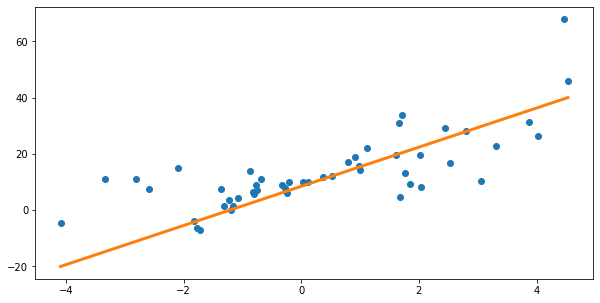

In [ ]:
np.random.seed(43)
X = np.sort(np.random.randn(50) * 2)
eps = np.random.randn(*X.shape) * 5
noise = X * eps
y = 5 * X + 10 + noise

X = X.reshape(-1,1)

X = torch.Tensor(X.astype('float32'))
y = torch.Tensor(y.astype('float32'))


plt.figure(figsize=(10,5))
plt.scatter(X,y)
plt.plot([X.min(), X.max()], [-20, 40], color='tab:orange', lw=3)
plt.show()

PyroModule является аналогом PyTorch nn.Module. Мы можем перейти от pytorch модуля к pyro модулю следующим образом:

In [ ]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

Мы можем в дальнейшем переопределять аттрибуты PyroModule в зависимости от наших задач.<br>
Рассмотрим классическую детерминированную линейную регрессию:

In [ ]:
model = PyroModule[nn.Linear](1, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.05)

num_iterations = 1500

def train():
    optim.zero_grad()
    y_pred = model(X).flatten()
    loss = loss_fn(y_pred, y)
    loss.backward()
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 229.8055
[iteration 0100] loss: 146.4056
[iteration 0150] loss: 109.6948
[iteration 0200] loss: 93.2184
[iteration 0250] loss: 84.8179
[iteration 0300] loss: 80.2358
[iteration 0350] loss: 77.8042
[iteration 0400] loss: 76.5966
[iteration 0450] loss: 76.0400
[iteration 0500] loss: 75.8021
[iteration 0550] loss: 75.7078
[iteration 0600] loss: 75.6731
[iteration 0650] loss: 75.6612
[iteration 0700] loss: 75.6575
[iteration 0750] loss: 75.6564
[iteration 0800] loss: 75.6561
[iteration 0850] loss: 75.6560
[iteration 0900] loss: 75.6560
[iteration 0950] loss: 75.6560
[iteration 1000] loss: 75.6560
[iteration 1050] loss: 75.6560
[iteration 1100] loss: 75.6560
[iteration 1150] loss: 75.6560
[iteration 1200] loss: 75.6560
[iteration 1250] loss: 75.6560
[iteration 1300] loss: 75.6560
[iteration 1350] loss: 75.6560
[iteration 1400] loss: 75.6560
[iteration 1450] loss: 75.6560
[iteration 1500] loss: 75.6560
Learned parameters:
weight [[4.827392]]
bias [11.835575]


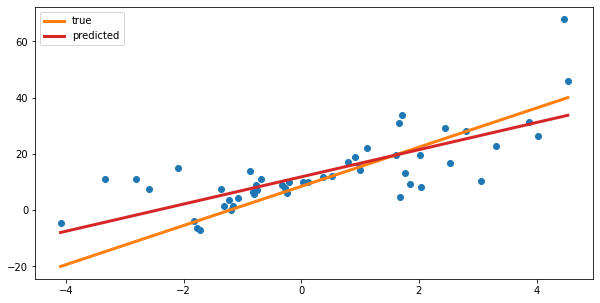

In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(X, y)
plt.plot([X.min(), X.max()], [-20, 40], color='tab:orange', lw=3, label='true')
plt.plot(X, model(X).detach(), color='tab:red', lw=3, label='predicted')
plt.legend()
plt.show()

Рассмотрим базовую линейную модель:
$$
f(x) = w\cdot x + b
$$


Перейдем теперь к вероятностой постановке и предположим следующие априорные распределения параметров:
$w \sim N(0,1)$, $b\sim N(0, 10)$.

Кроме того, мы предполагаем, что итоговое распределение $y$ будет также гауссовским со средним $f(x)$ и некой дисперсией $\sigma$.

В качестве априорного распределения для $\sigma$ возьмем равномерное $U(0, 20)$.

Напишем нашу модель, указав априорные распределения.

Метод .expand() используется для того, что сделать батч сэмплов определенного размера.<br>
Metod .to_event() декларирует, какое измерение является зависимым.<br>
Использование with pyro.plate('name', size) позволяет сделать итерации по условно независимым величинам.<br>

In [ ]:
from pyro.nn import PyroSample


class BayesianLinearRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 20.))
        mean = self.linear(x).squeeze(-1)
        
        with pyro.plate("data", x.shape[0]):
            # ...do conditionally independent stuff ...
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

Вместо того, чтобы расписывать guide функцию, которая определеят апостериорное распределение параметров можно воспользоваться готовой имплементацией.

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianLinearRegression(1, 1)
guide = AutoDiagonalNormal(model)

Переходим к оптимизации нашей модели:

In [ ]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

[iteration 0001] loss: 5.0028
[iteration 0101] loss: 4.2211
[iteration 0201] loss: 4.0697
[iteration 0301] loss: 3.8933
[iteration 0401] loss: 3.9193
[iteration 0501] loss: 3.8810
[iteration 0601] loss: 3.8578
[iteration 0701] loss: 3.8666
[iteration 0801] loss: 3.8682
[iteration 0901] loss: 3.8662
[iteration 1001] loss: 3.8625
[iteration 1101] loss: 3.8418
[iteration 1201] loss: 3.8637
[iteration 1301] loss: 3.8645
[iteration 1401] loss: 3.8540


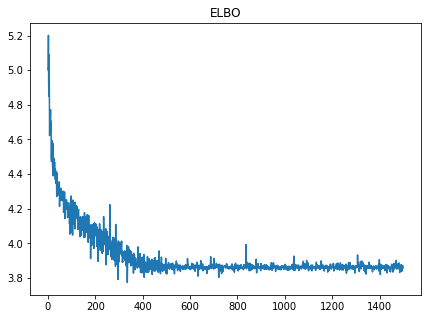

In [ ]:
pyro.clear_param_store()
elbo = []
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X, y)
    elbo.append(loss / len(X))
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, elbo[-1]))
        
plt.figure(figsize=(7, 5))
plt.plot(elbo)
plt.title('ELBO')
plt.show()

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-0.0733,  3.3682, 12.0374], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.2006, 0.5006, 1.3516], grad_fn=<SoftplusBackward>)


Теперь, при каждом запуске нашей модели, веса будут случайно сэмплироваться из своих апостериорных распределений.

**Вопрос**: Как получить итоговое предсказание, которое не будет случайным?

In [ ]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X)
print(samples['_RETURN'].shape)

torch.Size([800, 50])


In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.quantile(0.05, 0),
            "95%": v.quantile(0.95, 0),
        }
    return site_stats

pred_summary = summary(samples)

In [ ]:
mu = pred_summary["_RETURN"]
y_pred = pred_summary["obs"]

predictions = pd.DataFrame({
    "X": X[:,0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y_pred["mean"],
    "y_perc_5": y_pred["5%"],
    "y_perc_95": y_pred["95%"],
    "true_gdp": y,
})

**Вопрос**: Чем отличается mu от y_pred?

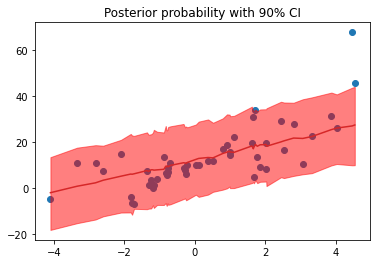

In [ ]:
plt.scatter(X[:,0], y)
plt.plot(X, predictions["y_mean"],color='tab:red')
plt.fill_between(X[:,0], predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5, color='red')
plt.title('Posterior probability with 90% CI')
plt.show()

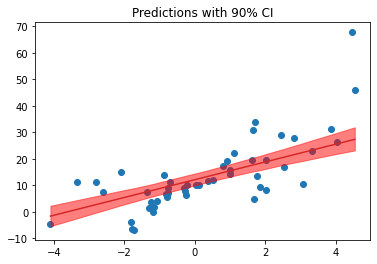

In [ ]:
plt.scatter(X[:,0], y)
plt.plot(X, predictions["mu_mean"],color='tab:red')
plt.fill_between(X[:,0], predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5, color='red')
plt.title('Predictions with 90% CI')
plt.show()

### Логистическая регрессия

Рассмотрим теперь другой датасет для задачи классификации

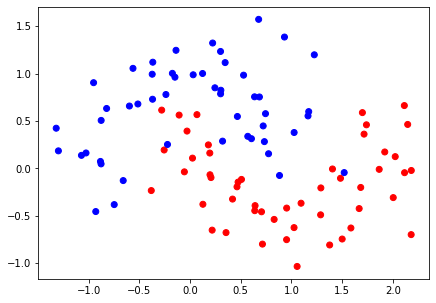

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(100, random_state=0, noise=0.3)
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
plt.show()

# Упражнение: 
Перепишите метод forward для линейной регрессии, чтобы получить многоклассовую логистическую регрессию.

In [ ]:
class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        logits = self.linear(x)
        probs = torch.softmax(logits, dim=1)
        
        with pyro.plate("data", x.shape[0]):
            # ...do conditionally independent stuff ...
            obs = pyro.sample("class", dist.Categorical(probs), obs=y)
        return probs

Проверим, что получилось

In [ ]:
model = BayesianLogisticRegression(2, 2)
guide = AutoDiagonalNormal(model)

[iteration 0001] loss: 1.6339
[iteration 0101] loss: 0.4818
[iteration 0201] loss: 0.4868
[iteration 0301] loss: 0.4618
[iteration 0401] loss: 0.4758
[iteration 0501] loss: 0.4647
[iteration 0601] loss: 0.4855
[iteration 0701] loss: 0.5196
[iteration 0801] loss: 0.5468
[iteration 0901] loss: 0.4694
[iteration 1001] loss: 0.4791
[iteration 1101] loss: 0.4715
[iteration 1201] loss: 0.4609
[iteration 1301] loss: 0.4133
[iteration 1401] loss: 0.4794


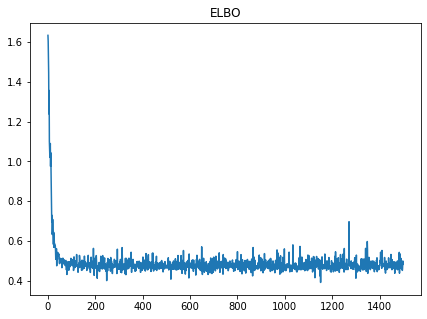

In [ ]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
elbo = []
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X, y)
    elbo.append(loss / len(X))
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, elbo[-1]))
        
plt.figure(figsize=(7, 5))
plt.plot(elbo)
plt.title('ELBO')
plt.show()

Посмотрим средний результат нашей модели:

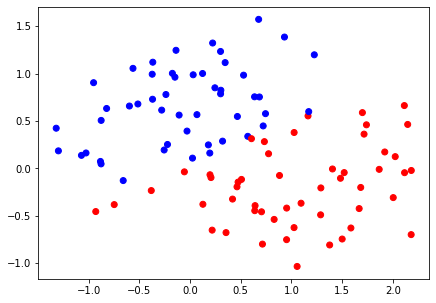

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=["_RETURN"])
samples = predictive(X)

y_mean = samples['_RETURN'].mean(0).argmax(1)


plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], c=y_mean, cmap='bwr')
plt.show()

**Вопрос**: Все ли ок?

Посмотрим теперь как ведет себя модель в разных областях нашей плоскости:

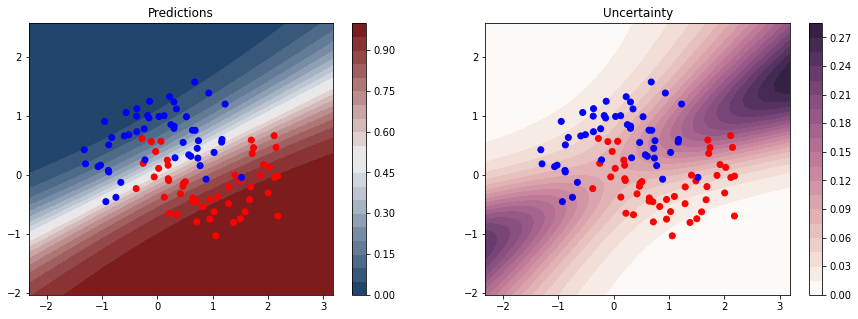

In [ ]:
xx = np.linspace(X[:, 0].min() - 1., X[:, 0].max() + 1., 50)
yy = np.linspace(X[:, 1].min() - 1., X[:, 1].max() + 1., 50)
mesh = np.meshgrid(xx, yy)
a = np.zeros((2500, 2))
a[:, 0], a[:, 1] = np.ravel(mesh[0]), np.ravel(mesh[1])
contour_test = torch.Tensor(a)

samples = predictive(contour_test)['_RETURN']
mean, std = samples.mean(0), samples.std(0)

contour_plot = mean.cpu().detach().numpy()[:, 1]
uncertainty_plot = std.cpu().detach().numpy()[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
contour = ax[0].contourf(mesh[0], mesh[1], contour_plot.reshape(50, 50), 20, cmap=cmap);
ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
ax[0].set_title('Predictions')
plt.colorbar(contour, ax=ax[0])

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
contour = ax[1].contourf(mesh[0], mesh[1], uncertainty_plot.reshape(50, 50), 20, cmap=cmap);
ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
ax[1].set_title('Uncertainty')
plt.colorbar(contour, ax=ax[1])

plt.show()

### EOF